In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [2]:
class ErrorSurfacePlotter:
    def __init__(self, w_range, b_range, X, Y, n_samples=30, go=True):
        W = np.linspace(-w_range, w_range, n_samples)
        B = np.linspace(-b_range, b_range, n_samples)
        w, b = np.meshgrid(W, B)    
        Z = np.zeros((30, 30))
        count1 = 0
        self.x = X.numpy()
        self.y = Y.numpy()
        for w1, b1 in zip(w, b):
            count2 = 0
            for w2, b2 in zip(w1, b1):
                yhat= 1 / (1 + np.exp(-1 * (w2*self.x + b2)))
                Z[count1,count2] = -1*np.mean(
                    self.y*np.log(yhat+1e-16) 
                    + (1-self.y)*np.log(1 - yhat + 1e-16))
                count2 += 1   
            count1 += 1
        self.Z = Z
        self.w = w
        self.b = b
        self.W = []
        self.B = []
        self.loss = []
        self.n = 0
        if go:
            plt.figure()
            plt.figure(figsize=(7.5, 5))
            plt.axes(projection='3d').plot_surface(
                self.w, 
                self.b, 
                self.Z, 
                rstride=1, 
                cstride=1, 
                cmap='viridis', 
                edgecolor='none')
            plt.title('Loss Surface')
            plt.xlabel('w')
            plt.ylabel('b')
            plt.show()
            plt.figure()
            plt.title('Loss Surface Contour')
            plt.xlabel('w')
            plt.ylabel('b')
            plt.contour(self.w, self.b, self.Z)
            plt.show()
            
     # Setter
    def set_para_loss(self, model, loss):
        self.n = self.n + 1
        self.W.append(list(model.parameters())[0].item())
        self.B.append(list(model.parameters())[1].item())
        self.loss.append(loss)
    
    # Plot diagram
    def plot_final(self): 
        ax = plt.axes(projection='3d')
        ax.plot_wireframe(self.w, self.b, self.Z)
        ax.scatter(
            self.W,
            self.B,
            self.loss,
            c='r',
            marker='x',
            s=200)
        plt.figure()
        plt.contour(self.w, self.b, self.Z)
        plt.scatter(self.W, self.B, c='r', marker='x')
        plt.xlabel('w')
        plt.ylabel('b')
        plt.show()
        
    # Plot diagram
    def plot_ps(self):
        plt.subplot(121)
        plt.ylim
        plt.plot(
            self.x[self.y==0],
            self.y[self.y==0],
            'ro',
            label='training points')
        plt.plot(
            self.x[self.y==1], 
            self.y[self.y==1] - 1, 
            'o', 
            label='training points')
        plt.plot(
            self.x,
            self.W[-1]*self.x + self.B[-1],
            label='fitted line')
        plt.xlabel('x')
        plt.ylabel('y')
        plt.ylim((-0.1, 2))
        plt.title(f'Data Space Iteration: {self.n}')
        plt.show()
        plt.subplot(122)
        plt.contour(self.w, self.b, self.Z)
        plt.scatter(self.W, self.B, c='r', marker='x')
        plt.title(f'Loss Surface Contour Iteration {self.n}')
        plt.xlabel('w')
        plt.ylabel('b')

In [3]:
def plot(X, Y, model, epoch, legend=True):
    plt.plot(
        X.numpy(),
        model(X).detach().numpy(), 
        label=f'epoch {epoch}')
    plt.plot(X.numpy(), Y.numpy(), 'r')
    if leg:
        plt.legend()

In [4]:
torch.manual_seed(0)

In [5]:
class Data(Dataset):
    def __init__(self):
        self.x = torch.arange(-1, 1, 0.1).view(-1, 1)
        self.y = torch.zeros(self.x.shape[0], 1)
        self.y[self.x[:, 0] > 0.2] = 1

    def __len__(self):
        return self.x.shape[0]
    
    def __getitem__(self, index):      
        return self.x[index], self.y[index]

In [6]:
data_set = Data()
data_set.x

tensor([[-1.0000],
        [-0.9000],
        [-0.8000],
        [-0.7000],
        [-0.6000],
        [-0.5000],
        [-0.4000],
        [-0.3000],
        [-0.2000],
        [-0.1000],
        [ 0.0000],
        [ 0.1000],
        [ 0.2000],
        [ 0.3000],
        [ 0.4000],
        [ 0.5000],
        [ 0.6000],
        [ 0.7000],
        [ 0.8000],
        [ 0.9000]])

In [7]:
data_set.y

tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]])

In [8]:
len(data_set)

20

In [9]:
x, y = data_set[0]
print(f'x = {x},  y = {y}')

x = tensor([-1.]),  y = tensor([0.])


In [10]:
x, y = data_set[1]
print(f'x = {x},  y = {y}')

x = tensor([-0.9000]),  y = tensor([0.])


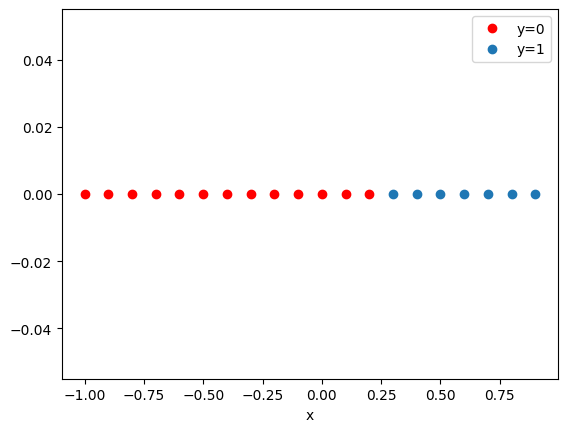

In [12]:
plt.plot(
    data_set.x[data_set.y==0], 
    data_set.y[data_set.y==0], 
    'ro', 
    label='y=0')
plt.plot(
    data_set.x[data_set.y==1],
    data_set.y[data_set.y==1] - 1,
    'o',
    label='y=1')
plt.xlabel('x')
plt.legend();

In [17]:
class LogisticRegression(nn.Module):
    def __init__(self, n_inputs):
        super().__init__()
        self.linear = nn.Linear(n_inputs, 1)
        
    def forward(self, x):
        yhat = torch.sigmoid(self.linear(x))
        return yhat

In [18]:
x, y = data_set[0]
len(x)

1

In [19]:
model = LogisticRegression(1)

In [20]:
x = torch.tensor([-1.0])
sigma = model(x)
sigma

tensor([0.6327], grad_fn=<SigmoidBackward0>)

In [21]:
x, y = data_set[2]
sigma = model(x)
sigma

tensor([0.6324], grad_fn=<SigmoidBackward0>)

<Figure size 640x480 with 0 Axes>

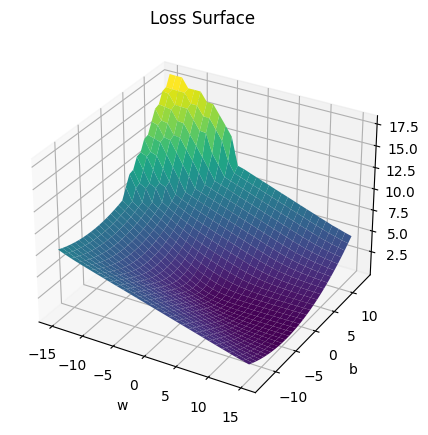

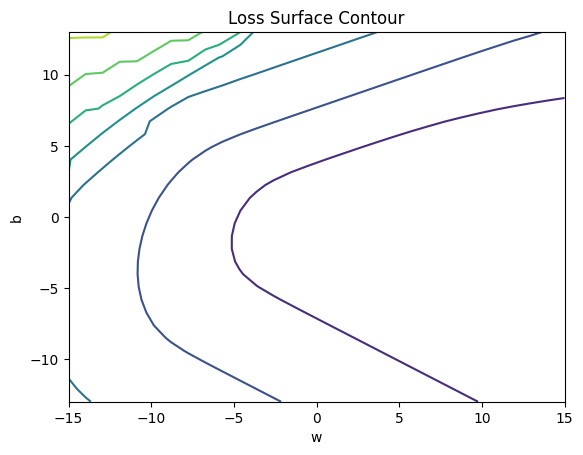

In [23]:
surface_plotter = ErrorSurfacePlotter(
    15, 13, data_set[:][0], data_set[:][1])

In [24]:
criterion = nn.BCELoss()
x, y = data_set[0]
print(f'x = {x},  y = {y}')

x = tensor([-1.]),  y = tensor([0.])


In [25]:
sigma = model(x)
sigma

tensor([0.6327], grad_fn=<SigmoidBackward0>)

In [26]:
loss = criterion(sigma, y)
loss

tensor(1.0016, grad_fn=<BinaryCrossEntropyBackward0>)

In [28]:
batch_size = 10
train_loader = DataLoader(dataset=data_set, batch_size=batch_size)
dataset_iter = iter(train_loader)
X, y = next(dataset_iter)
X

tensor([[-1.0000],
        [-0.9000],
        [-0.8000],
        [-0.7000],
        [-0.6000],
        [-0.5000],
        [-0.4000],
        [-0.3000],
        [-0.2000],
        [-0.1000]])

In [29]:
eta = 0.1
optim = torch.optim.SGD(model.parameters(), lr=eta)

<Figure size 640x480 with 0 Axes>

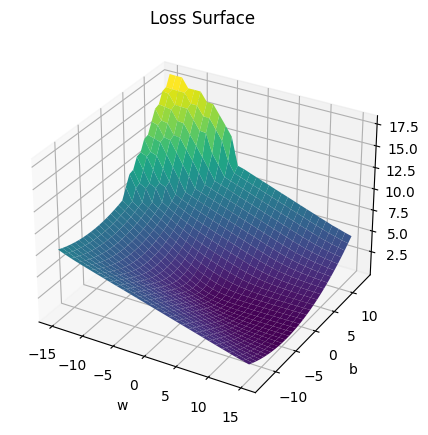

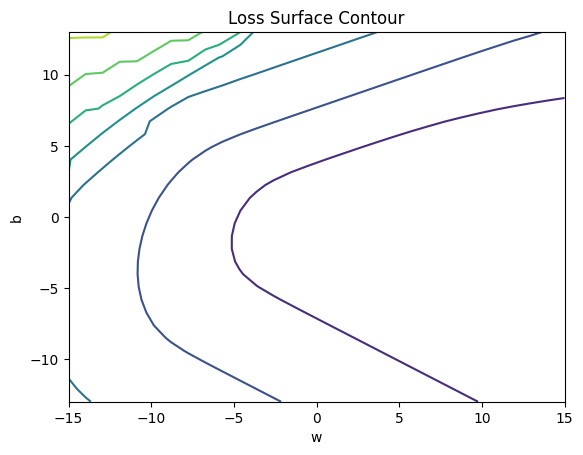

In [30]:
surface_plotter = ErrorSurfacePlotter(
    15, 13, data_set[:][0], data_set[:][1], 30)

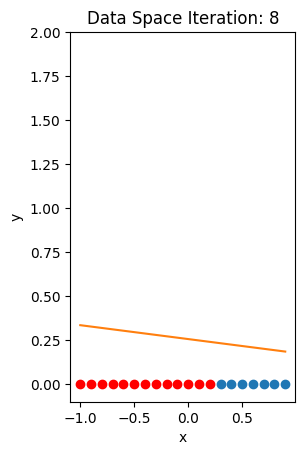

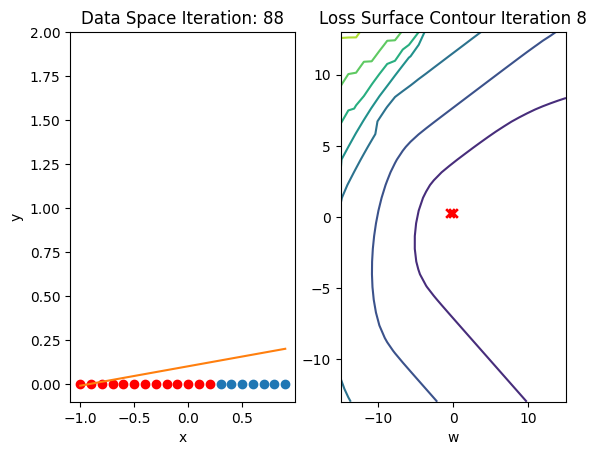

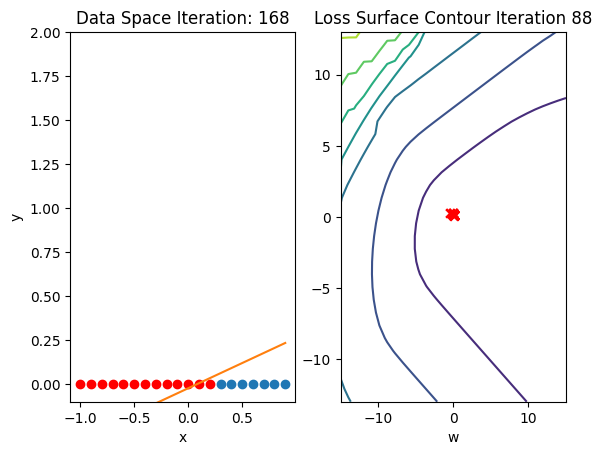

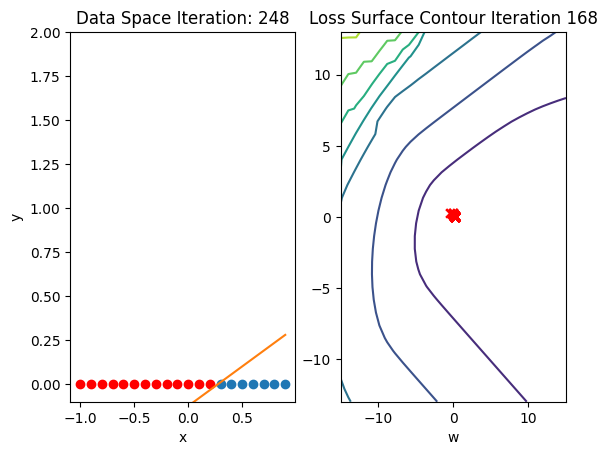

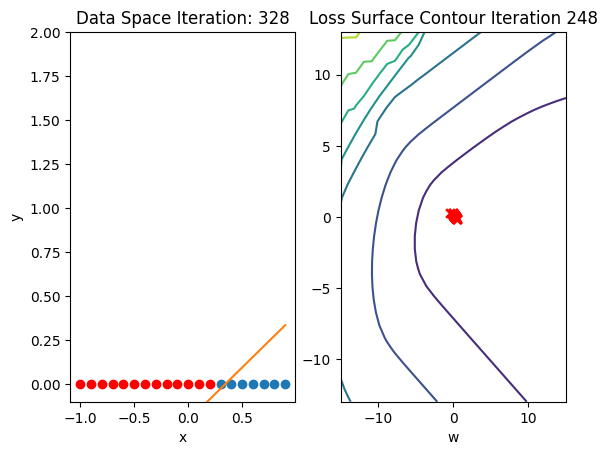

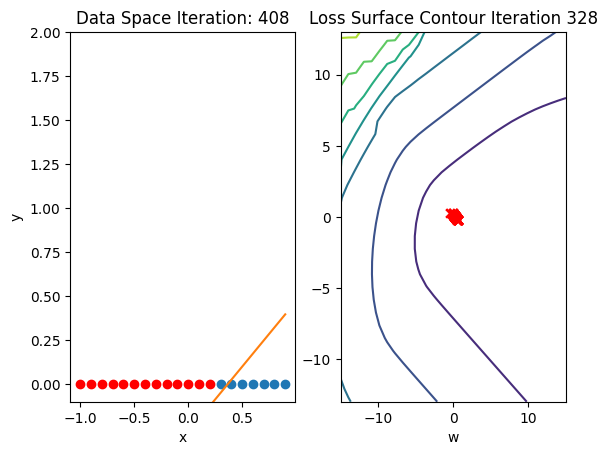

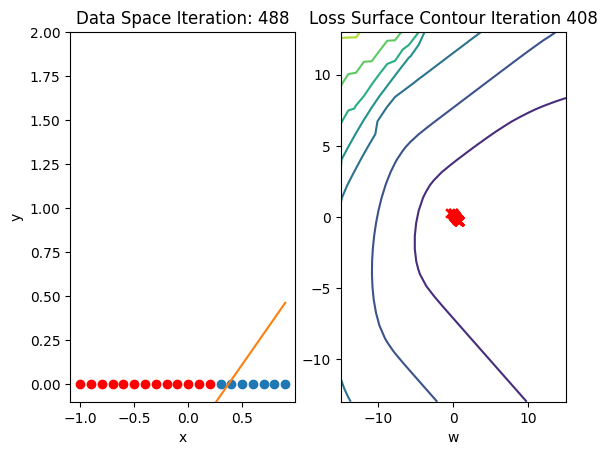

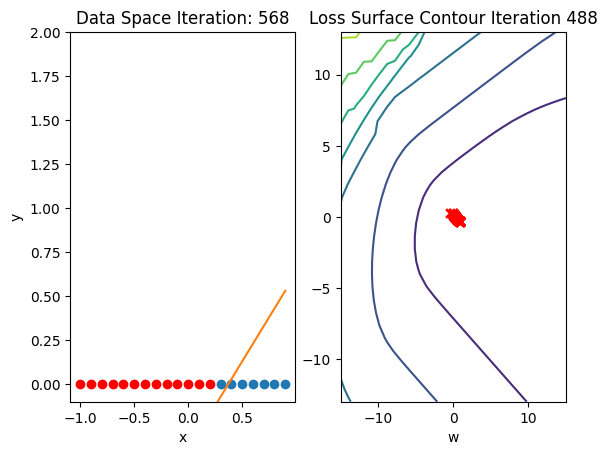

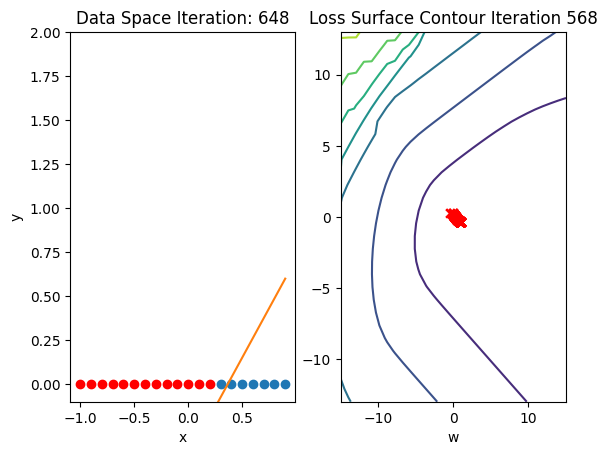

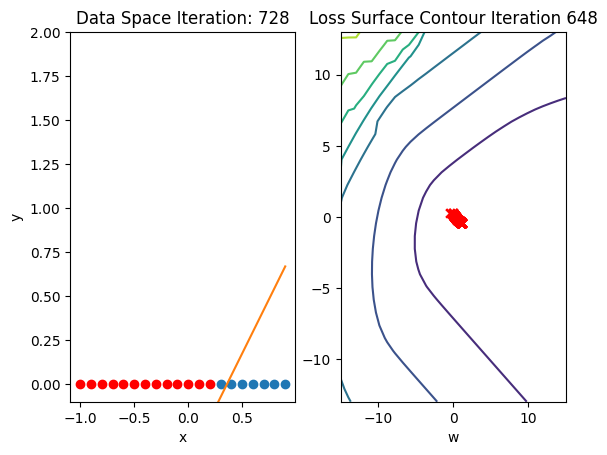

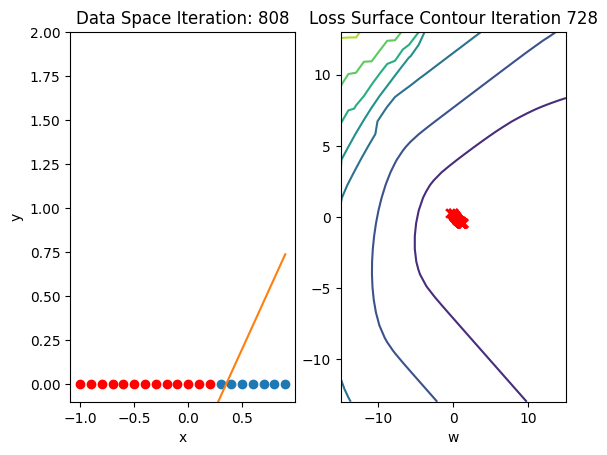

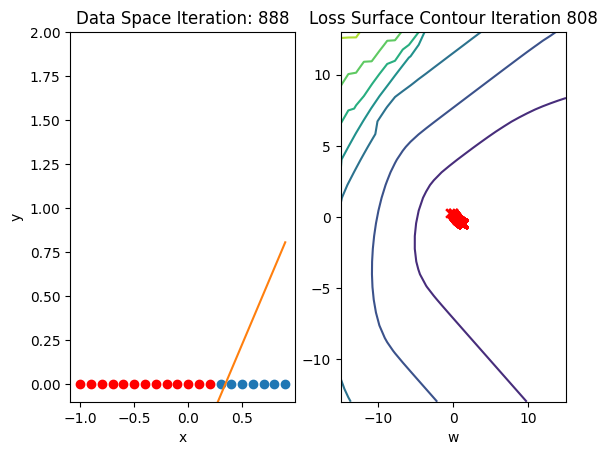

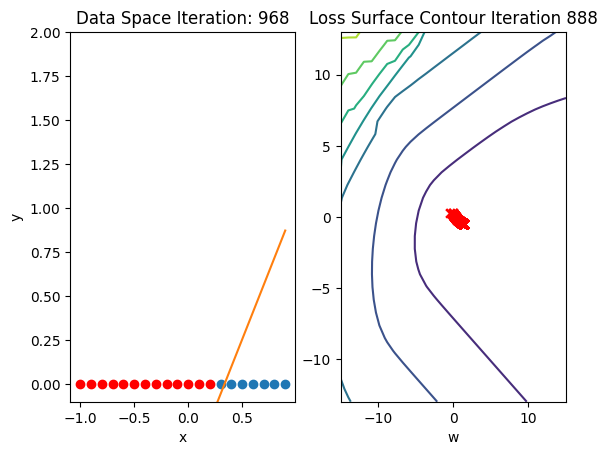

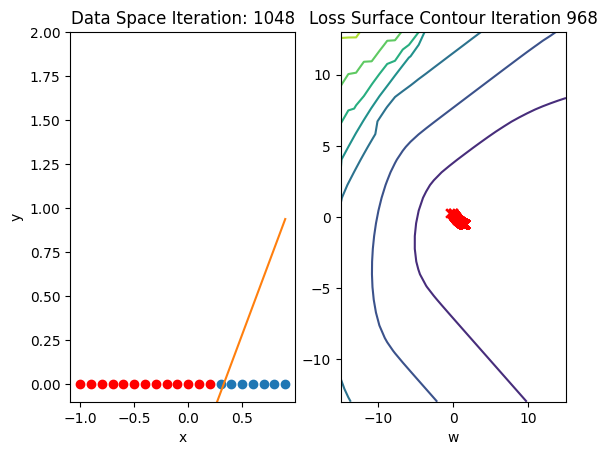

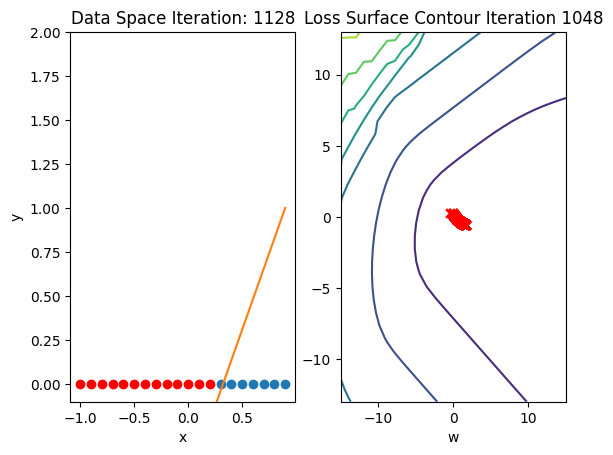

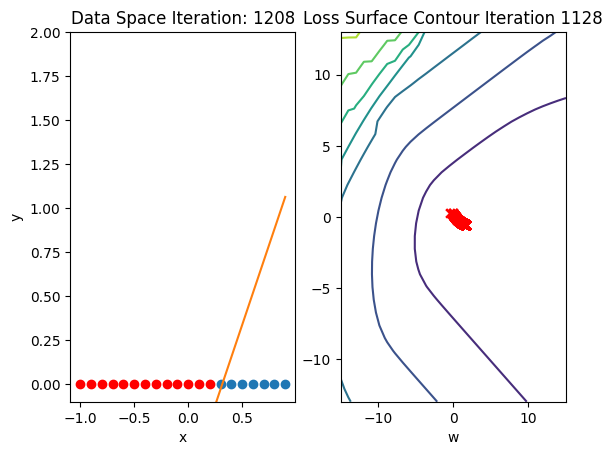

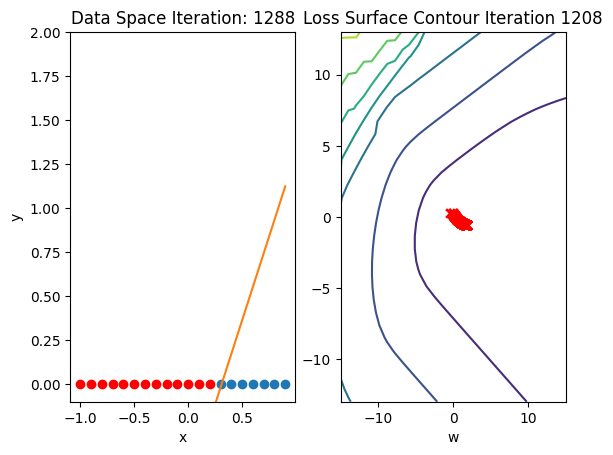

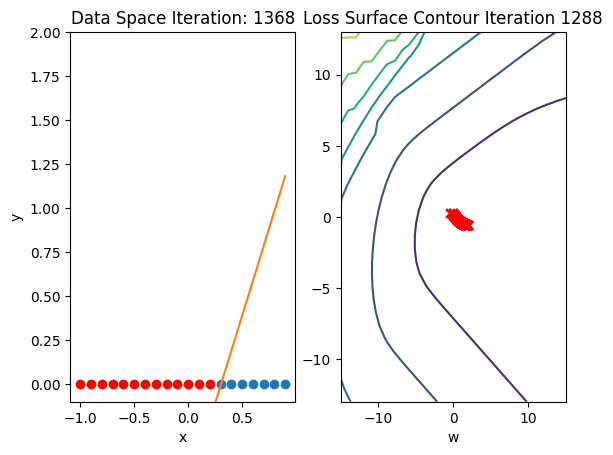

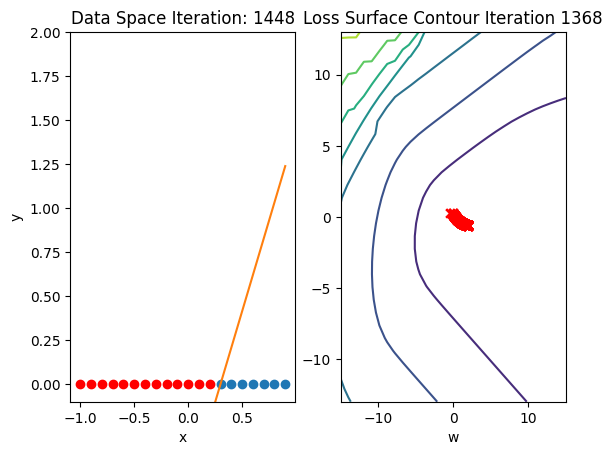

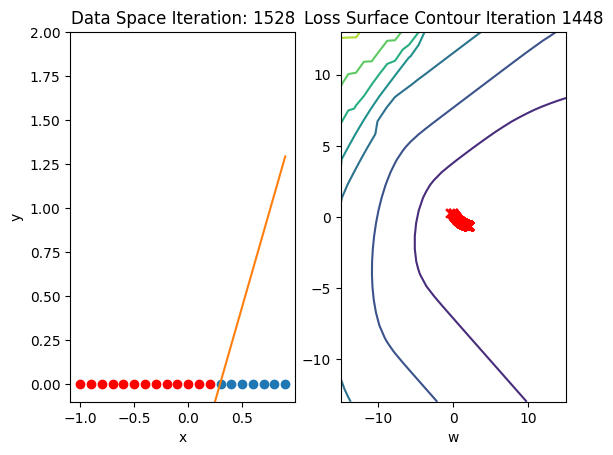

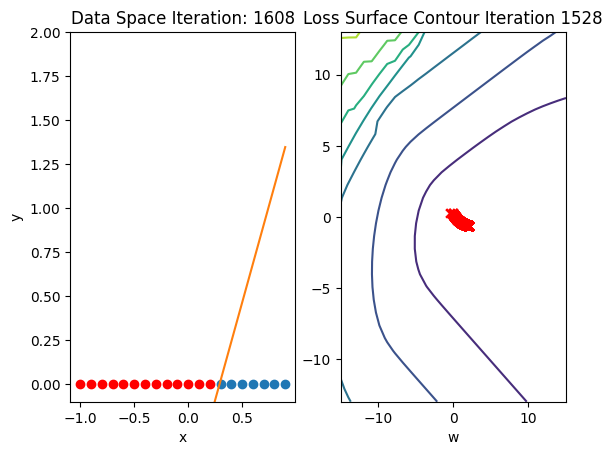

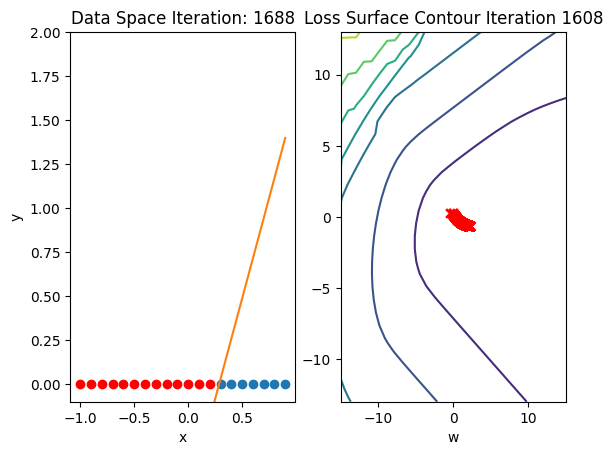

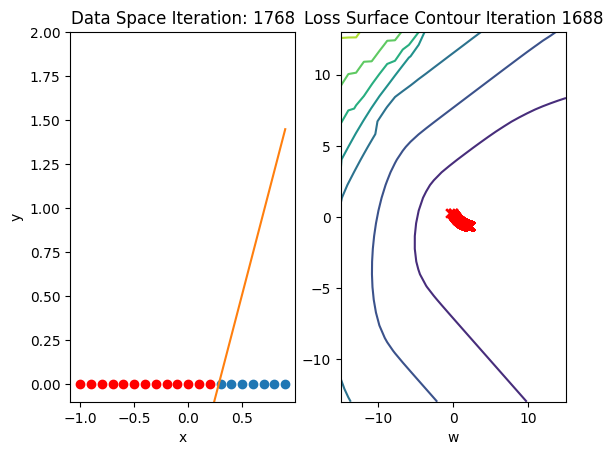

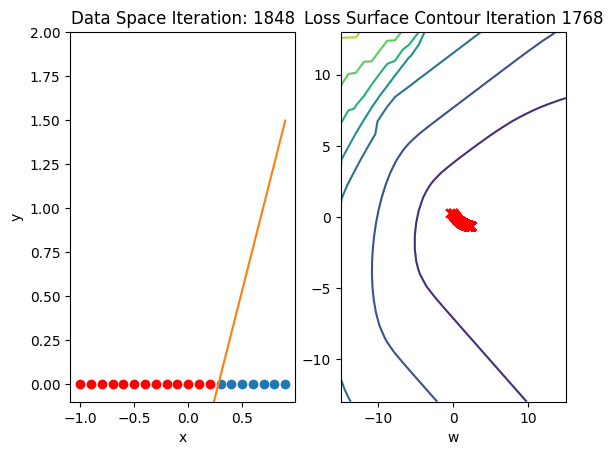

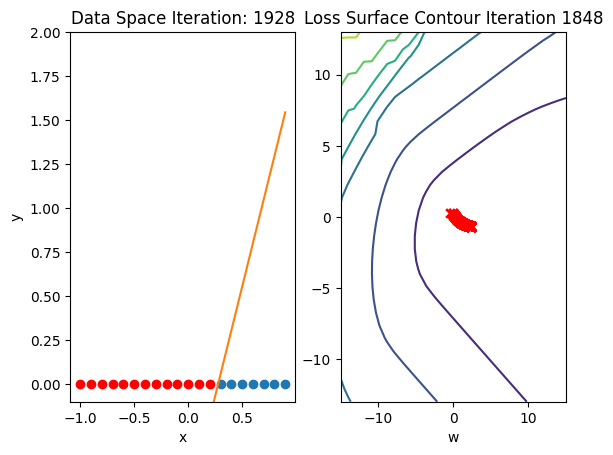

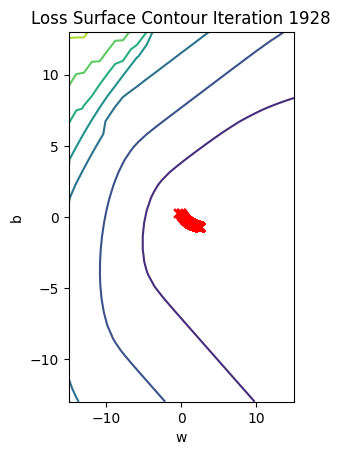

In [33]:
model = LogisticRegression(1)
criterion = nn.BCELoss()
train_loader = DataLoader(dataset=data_set, batch_size=5)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
epochs = 500
loss_values = []

for epoch in range(epochs):
    for x, y in train_loader:
        yhat = model(x)
        loss = criterion(yhat, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        surface_plotter.set_para_loss(model, loss.tolist())
        loss_values.append(loss)
    if epoch % 20 == 0:
        surface_plotter.plot_ps()

In [34]:
w = model.state_dict()['linear.weight'].data[0]
b = model.state_dict()['linear.bias'].data[0]
print(f'w = {w}, b = {b}')

w = tensor([2.5409]), b = -0.6991032361984253


In [35]:
yhat = model(data_set.x)
yhat = torch.round(yhat)
correct = 0
for prediction, actual in zip(yhat, data_set.y):
    if (prediction == actual):
        correct += 1
print(f'Accuracy: {100 * correct / len(data_set)}%')

Accuracy: 100.0%


Text(0, 0.5, 'Cost')

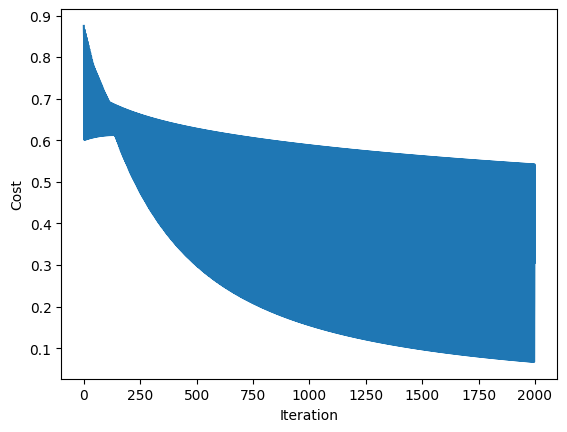

In [36]:
loss_bgd1 = []
for i in loss_values:
    loss_bgd1.append(i.item())
plt.plot(loss_bgd1)
plt.xlabel('Iteration')
plt.ylabel('Cost')

<Figure size 640x480 with 0 Axes>

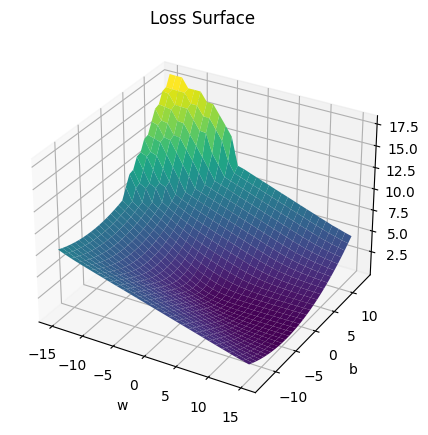

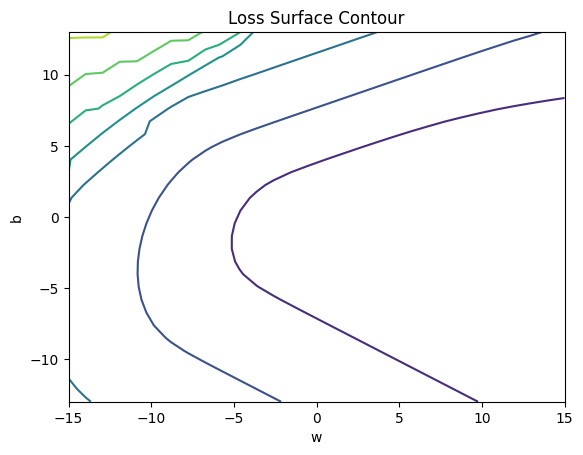

In [42]:
surface_plotter = ErrorSurfacePlotter(
    15, 13, data_set[:][0], data_set[:][1], 30)

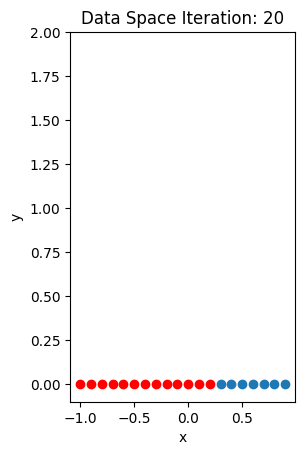

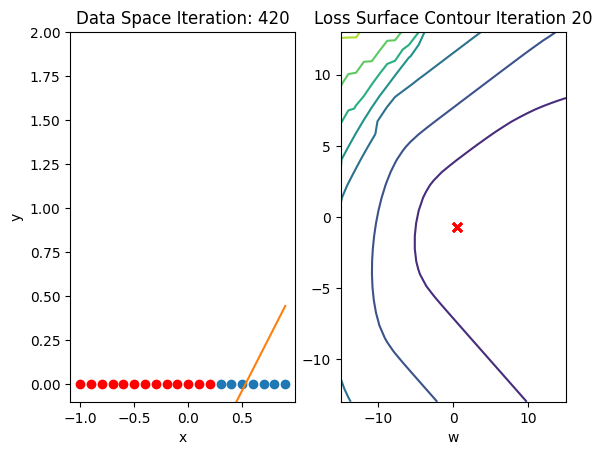

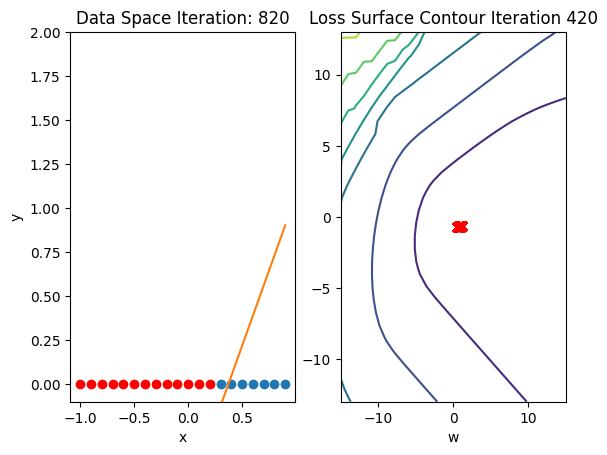

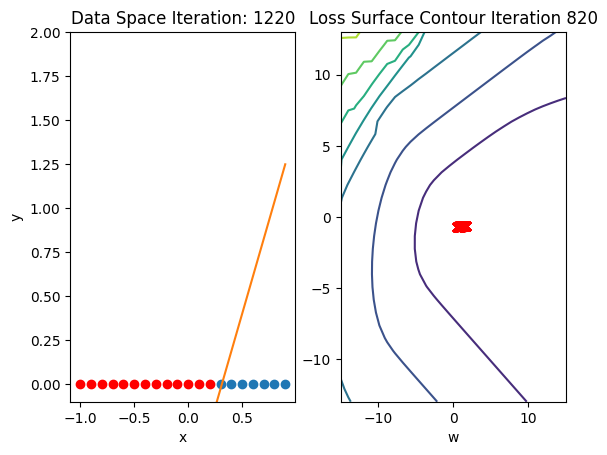

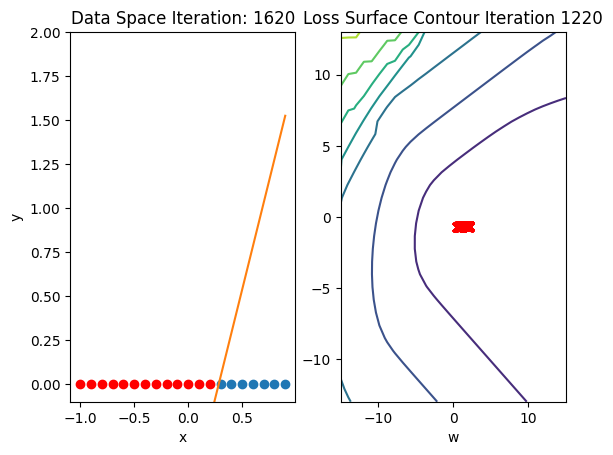

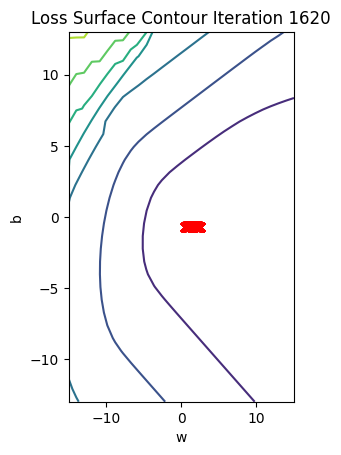

In [44]:
model = LogisticRegression(1)
criterion = nn.BCELoss()
train_loader = DataLoader(dataset=data_set, batch_size=1)
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01)
epochs = 100
loss_values = []
for epoch in range(epochs):
    for x, y in train_loader:
        yhat = model(x)
        loss = criterion(yhat, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        surface_plotter.set_para_loss(model, loss.tolist())
        loss_values.append(loss)
    if epoch % 20 == 0:
        surface_plotter.plot_ps()

In [45]:
w = model.state_dict()['linear.weight'].data[0]
b = model.state_dict()['linear.bias'].data[0]
print(f'w = {w}, b = {b}')

w = tensor([2.7585]), b = -0.7400428056716919


In [46]:
yhat = model(data_set.x)
yhat = torch.round(yhat)
correct = 0
for prediction, actual in zip(yhat, data_set.y):
    if (prediction == actual):
        correct += 1
print(f'Accuracy: {100 * correct / len(data_set)}%')

Accuracy: 100.0%


Text(0, 0.5, 'Cost')

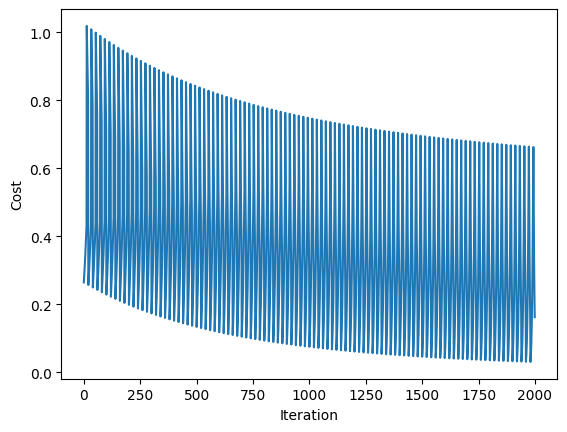

In [49]:
loss_bgd1=[]
for i in loss_values:
    loss_bgd1.append(i.item())

plt.plot(loss_bgd1)
plt.xlabel('Iteration')
plt.ylabel('Cost')

<Figure size 640x480 with 0 Axes>

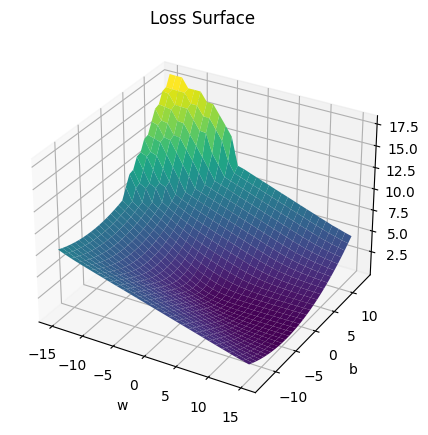

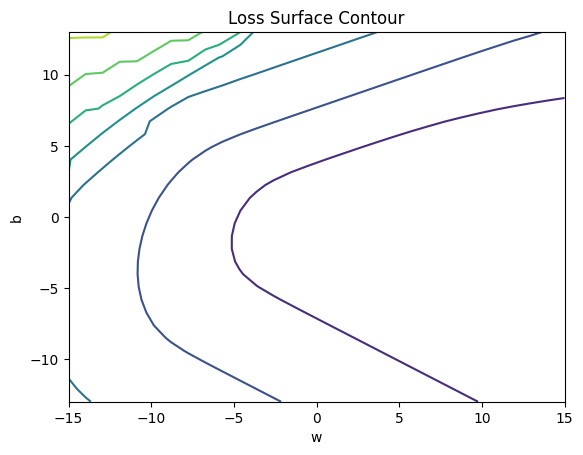

In [50]:
plotter = ErrorSurfacePlotter(
    15, 13, data_set[:][0], data_set[:][1], 30)

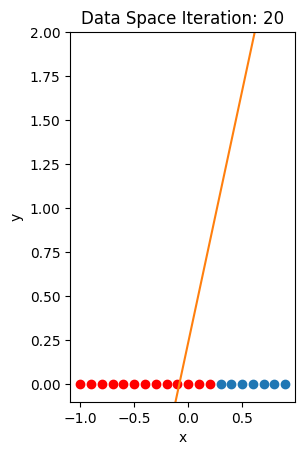

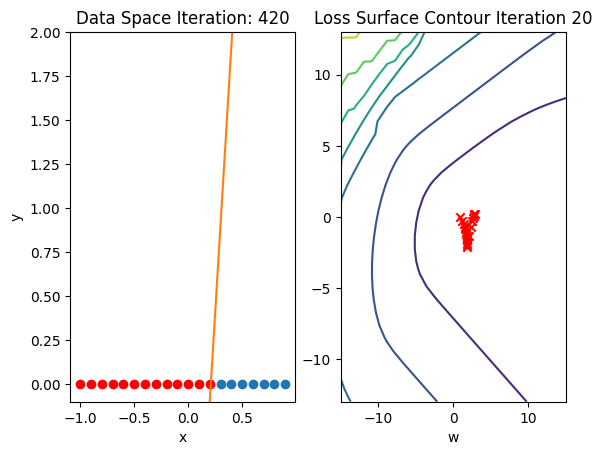

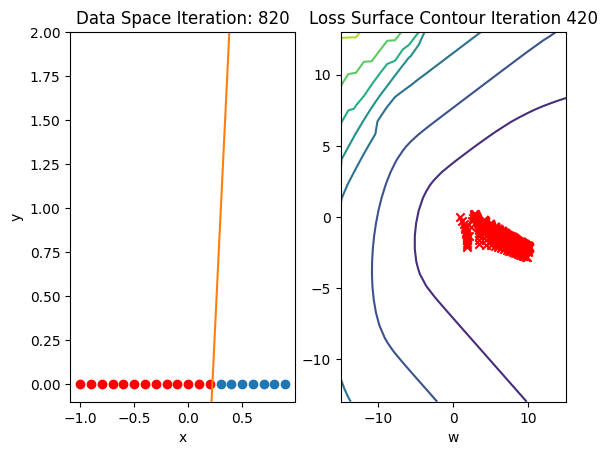

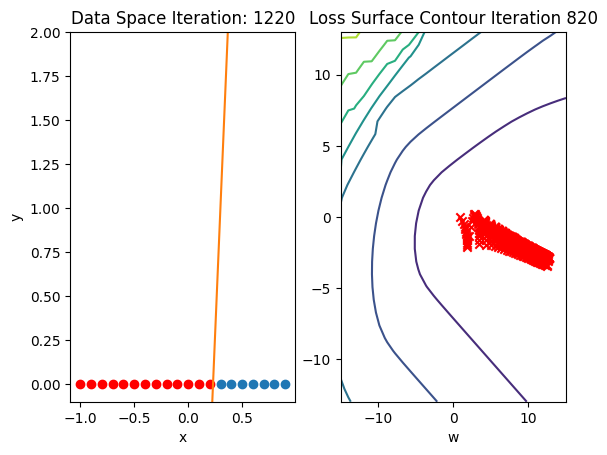

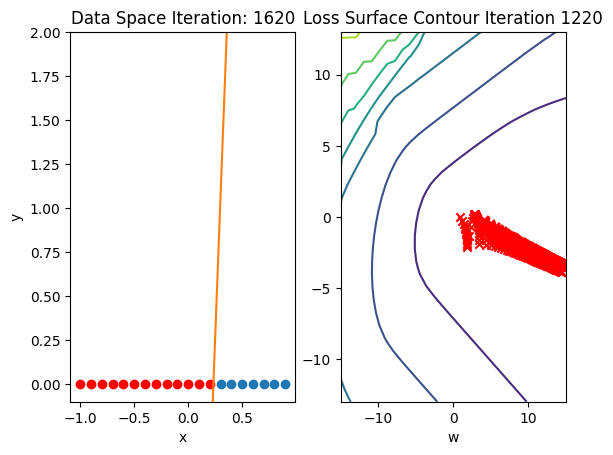

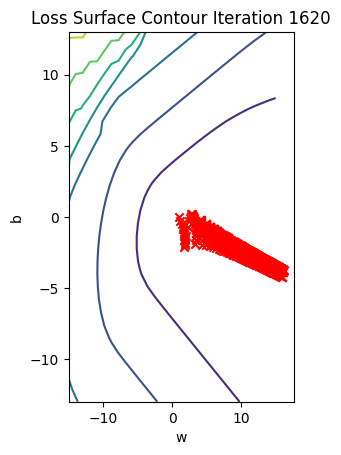

In [52]:
model = LogisticRegression(1)
criterion = nn.BCELoss()
train_loader = DataLoader(dataset=data_set, batch_size=1)
optimizer = torch.optim.SGD(model.parameters(), lr=1)
epochs = 100
loss_values = []

for epoch in range(epochs):
    for x, y in train_loader:
        yhat = model(x)
        loss = criterion(yhat, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        plotter.set_para_loss(model, loss.tolist())
        loss_values.append(loss)
    if epoch % 20 == 0:
        plotter.plot_ps()

In [53]:
w = model.state_dict()['linear.weight'].data[0]
b = model.state_dict()['linear.bias'].data[0]
print(f'w = {w}, b = {b}')

w = tensor([17.3171]), b = -4.08909273147583


In [54]:
yhat = model(data_set.x)
yhat = torch.round(yhat)
correct = 0
for prediction, actual in zip(yhat, data_set.y):
    if (prediction == actual):
        correct += 1
print(f'Accuracy: {100 * correct / len(data_set)}%')

Accuracy: 100.0%


Text(0, 0.5, 'Cost')

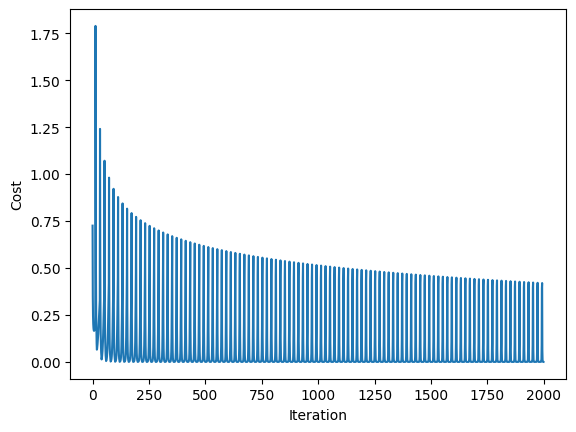

In [55]:
loss_bgd1=[]
for i in loss_values:
    loss_bgd1.append(i.item())

plt.plot(loss_bgd1)
plt.xlabel('Iteration')
plt.ylabel('Cost')